In [1]:
%run /Desktop/Share/CUDA_DEVICE_setup.py -n 1

using GPU ID:0,



In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"  # set as the using GPU ID

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Build the Dataset

In [4]:
class DeepCaloDataset(Dataset):
    def __init__(self, data_path, target_path, transform=None):
        """
        Initialize the dataset with data and target paths.
        
        Parameters:
        data_path (str): Path to the .npy file containing image data.
        target_path (str): Path to the .npy file containing target data.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = np.load(data_path).astype(np.float32)
        self.targets = np.load(target_path).astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]

        # Permute the sample to have the channel dimension first
        sample = np.transpose(sample, (2, 0, 1))  # From [56, 11, 4] to [4, 56, 11]

        target = np.expand_dims(target, -1)
        if self.transform:
            sample = self.transform(sample)

        return sample, target

In [5]:
#Define file paths
base_path = '/Desktop/CodeFolder/PCS/dataset/DeepCalo100K'
#base_path = '.'
train_data_path = f'{base_path}/dcalo_img_train.npy'
train_target_path = f'{base_path}/dcalo_img_train_target.npy'
val_data_path = f'{base_path}/dcalo_img_val.npy'
val_target_path = f'{base_path}/dcalo_img_val_target.npy'
test_data_path = f'{base_path}/dcalo_img_test.npy'
test_target_path = f'{base_path}/dcalo_img_test_target.npy'

In [6]:
# Create datasets
train_dataset = DeepCaloDataset(train_data_path, train_target_path)
val_dataset = DeepCaloDataset(val_data_path, val_target_path)
test_dataset = DeepCaloDataset(test_data_path, test_target_path)

In [7]:
# Create dataloaders
tr_batch_size = 64
test_batch_size = 16


train_loader = DataLoader(train_dataset, batch_size=tr_batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)

## Have a look at images for DeepCalo
Each image has a shape of (56, 11, 4), 4 channel currosponding to 4 layers if electromegnatic calorememter

In [8]:
import matplotlib.pyplot as plt

In [9]:

# Get the first batch 
data_iter = iter(test_loader)
batch = next(data_iter)

# Extract samples and targets
# Show the first 2 data
samples, targets = batch
samples, targets = samples[:2], targets[:2]

print(samples.shape)
print(targets.shape)

torch.Size([2, 4, 56, 11])
torch.Size([2, 1])


First image: 
Target: 146.55


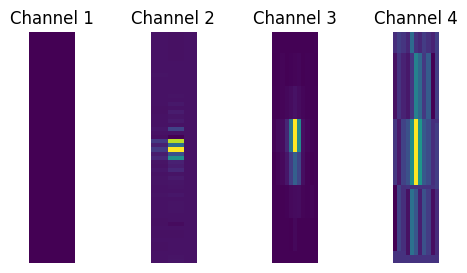

Seocnd image: 
Target: 101.04


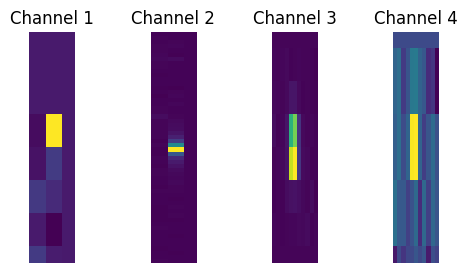

In [10]:
print("First image: ")
print(f"Target: {targets[0].item():.2f}")

# Plot each channel separately
plt.figure(figsize=(6, 3))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(samples[0][i])
    plt.axis('off')
    plt.title(f"Channel {i + 1}")

plt.show()

print("Seocnd image: ")
print(f"Target: {targets[1].item():.2f}")

plt.figure(figsize=(6, 3))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(samples[1][i])
    plt.axis('off')
    plt.title(f"Channel {i + 1}")
plt.show()   


# DeepCalo Model

In [11]:
import torch.optim as optim

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
print(device)

cuda


In [14]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import brevitas.nn as qnn

class DeepCaloModelFull(nn.Module):
    def __init__(self):
        super(DeepCaloModelFull, self).__init__()
        
        self.upsample = nn.Upsample(scale_factor=(1, 5), mode='nearest')
        
        self.conv1 = nn.Conv2d(4, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.block1_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block1_conv1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.block1_conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        
        self.block2_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block2_conv1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.block2_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        
        self.block3_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block3_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(128)
        self.block3_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(128)

        self.block4_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block4_conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(256)
        self.block4_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.upsample(x)
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.block1_pool(x)
        x = F.relu(self.bn1_1(self.block1_conv1(x)))
        x = F.relu(self.bn1_2(self.block1_conv2(x)))

        x = self.block2_pool(x)
        x = F.relu(self.bn2_1(self.block2_conv1(x)))
        x = F.relu(self.bn2_2(self.block2_conv2(x)))

        x = self.block3_pool(x)
        x = F.relu(self.bn3_1(self.block3_conv1(x)))
        x = F.relu(self.bn3_2(self.block3_conv2(x)))

        x = self.block4_pool(x)
        x = F.relu(self.bn4_1(self.block4_conv1(x)))
        x = F.relu(self.bn4_2(self.block4_conv2(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.relu(x)
        return x

In [15]:
deep_calo_model = DeepCaloModelFull().to(device)

In [16]:
from torchinfo import summary

In [17]:
summary(deep_calo_model, input_shape = [1, 56, 11, 4])

Layer (type:depth-idx)                   Param #
DeepCaloModelFull                        --
├─Upsample: 1-1                          --
├─Conv2d: 1-2                            1,616
├─BatchNorm2d: 1-3                       32
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            4,640
├─BatchNorm2d: 1-6                       64
├─Conv2d: 1-7                            9,248
├─BatchNorm2d: 1-8                       64
├─MaxPool2d: 1-9                         --
├─Conv2d: 1-10                           18,496
├─BatchNorm2d: 1-11                      128
├─Conv2d: 1-12                           36,928
├─BatchNorm2d: 1-13                      128
├─MaxPool2d: 1-14                        --
├─Conv2d: 1-15                           73,856
├─BatchNorm2d: 1-16                      256
├─Conv2d: 1-17                           147,584
├─BatchNorm2d: 1-18                      256
├─MaxPool2d: 1-19                        --
├─Conv2d: 1-20                           

In [18]:
deep_calo_model

DeepCaloModelFull(
  (upsample): Upsample(scale_factor=(1.0, 5.0), mode=nearest)
  (conv1): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block1_conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2_conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2_conv2): Conv2d(64, 64, kernel_size=

# Train the initial model 

In [19]:
def mean_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

In [20]:
best_model_path = 'best_deepalo_model.pth'

In [21]:
def train_model(deep_calo_model, train_loader, test_loader, num_epochs=10, lr=0.001, best_model_path = 'best_deepalo_model.pth'):
    # Define the loss function and the optimizer
    criterion = nn.L1Loss()  # Mean Absolute Error (MAE) Loss
    optimizer = optim.Adam(deep_calo_model.parameters(), lr=lr)

    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []

    best_loss = float('inf')  # Initialize the best loss to a high value
      # Path to save the best model

    print("Start Training:")
    for epoch in range(num_epochs):  # Loop over the dataset multiple times
        running_loss = 0.0  # Initialize the running loss for each epoch
        total_mae = 0.0  # Initialize the running MAE for each epoch
        total = 0

        deep_calo_model.train()  # Set the network to training mode

        for data in train_loader:
            # Get the inputs and labels from the data loader
            inputs, labels = data

            # Move the inputs and labels to the specified device (CPU or GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients to avoid accumulation from previous iterations
            optimizer.zero_grad()

            # Perform the forward pass: compute the network's outputs
            outputs = deep_calo_model(inputs)

            # Compute the loss using the criterion
            loss = criterion(outputs, labels)

            # Perform the backward pass: compute the gradients
            loss.backward()

            # Update the network parameters using the optimizer
            optimizer.step()

            # Accumulate the loss for the current mini-batch
            running_loss += loss.item()

            # Calculate MAE for the current mini-batch
            total_mae += mean_absolute_error(outputs.cpu(), labels.cpu()) * inputs.size(0)
            total += inputs.size(0)

        train_loss = running_loss / len(train_loader)
        train_mae = total_mae / total
        train_accuracies.append(train_mae)
        train_losses.append(train_loss)

        # Evaluate on the test set
        deep_calo_model.eval()  # Set the network to evaluation mode
        test_mae = 0.0
        test_loss = 0.0
        total_test = 0

        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = deep_calo_model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                test_mae += mean_absolute_error(outputs.cpu(), labels.cpu()) * inputs.size(0)
                total_test += inputs.size(0)

        test_loss /= len(test_loader)
        test_mae /= total_test
        test_accuracies.append(test_mae)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Training MAE: {train_mae:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

        # Check if this is the best model so far
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(deep_calo_model.state_dict(), best_model_path)
            print(f'Saved model with test loss: {best_loss:.4f}')

    print('Finished Training')
    return train_accuracies, train_losses, test_accuracies, test_losses

In [22]:
# Function to test the model performance on the test data for first 5 batches
def test_model(model, test_loader, device, num_batches=5):

    criterion = nn.L1Loss()  # Mean Absolute Error (MAE) Loss
    model.eval()  # Set the model to evaluation mode
    test_mae = 0.0
    test_loss = 0.0
    total_test = 0
    batch_count = 0

    with torch.no_grad():
        for data in test_loader:
            if batch_count >= num_batches:
                break

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_mae += mean_absolute_error(outputs.cpu(), labels.cpu()) * inputs.size(0)
            total_test += inputs.size(0)
            batch_count += 1

            print(f'Batch {batch_count}, Test MAE: {mean_absolute_error(outputs.cpu(), labels.cpu()):.4f}, Test Loss: {loss.item():.4f}')

    test_loss /= batch_count
    test_mae /= total_test
    print(f'Average Test MAE for first {num_batches} batches: {test_mae:.4f}')
    print(f'Average Test Loss for first {num_batches} batches: {test_loss:.4f}')

In [45]:
# train 第一遍

load_pretrain = True
if load_pretrain:
    print("Load pretrained DeepCalo: ", best_model_path)
    deep_calo_model = DeepCaloModelFull().to(device)
    deep_calo_model.load_state_dict(torch.load(best_model_path))
    test_model(deep_calo_model, test_loader, device, num_batches=5)
else:
    train_accuracies, train_losses, test_accuracies, test_losses = \
    train_model(deep_calo_model, train_loader, test_loader, num_epochs=100, lr = 0.001, best_model_path = best_model_path)



Load pretrained DeepCalo:  best_deepalo_model.pth
Batch 1, Test MAE: 7.8209, Test Loss: 7.8209
Batch 2, Test MAE: 4.6491, Test Loss: 4.6491
Batch 3, Test MAE: 8.6994, Test Loss: 8.6994
Batch 4, Test MAE: 4.3375, Test Loss: 4.3375
Batch 5, Test MAE: 3.7579, Test Loss: 3.7579
Average Test MAE for first 5 batches: 5.8530
Average Test Loss for first 5 batches: 5.8530


# Prune

In [46]:
model = deep_calo_model
print(model)

DeepCaloModelFull(
  (upsample): Upsample(scale_factor=(1.0, 5.0), mode=nearest)
  (conv1): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block1_conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2_conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2_conv2): Conv2d(64, 64, kernel_size=

In [47]:
import torch_pruning as tp

In [48]:
?tp.importance.MagnitudeImportance

Init signature:
tp.importance.MagnitudeImportance(
    p: int = 2,
    group_reduction: str = 'mean',
    normalizer: str = 'mean',
    bias=False,
    target_types: list = [<class 'torch.nn.modules.conv._ConvNd'>, <class 'torch.nn.modules.linear.Linear'>, <class 'torch.nn.modules.batchnorm._BatchNorm'>, <class 'torch.nn.modules.normalization.LayerNorm'>],
)
Docstring:     
A general implementation of magnitude importance. By default, it calculates the group L2-norm for each channel/dim.
It supports several variants like:
    - Standard L1-norm of the first layer in a group: MagnitudeImportance(p=1, normalizer=None, group_reduction="first")
    - Group L1-Norm: MagnitudeImportance(p=1, normalizer=None, group_reduction="mean")
    - BN Scaling Factor: MagnitudeImportance(p=1, normalizer=None, group_reduction="mean", target_types=[nn.modules.batchnorm._BatchNorm])

Args:
    * p (int): the norm degree. Default: 2
    * group_reduction (str): the reduction method for group importance. Def

In [49]:
# 0. importance criterion for parameter selections
imp = tp.importance.MagnitudeImportance(p=2, group_reduction='mean')

In [50]:
ignored_layers = []
for m in model.modules():
    # ignore the final layer only
    if isinstance(m, torch.nn.Linear) and m.out_features == 1:
    #if isinstance(m, torch.nn.Linear):
        ignored_layers.append(m)

In [51]:
ignored_layers

[Linear(in_features=256, out_features=1, bias=True)]

In [52]:
example_inputs = torch.randn(1, 4, 56, 11).to(device)

In [53]:
base_macs, base_nparams = tp.utils.count_ops_and_params(model, example_inputs)

overall_list = []

for i in range(10):
    # 3. the pruner.step will remove some channels from the model with least importance
    iterative_steps = 1 # You can prune your model to the target pruning ratio iteratively.
    pruner = tp.pruner.MagnitudePruner(
        model, 
        example_inputs, 
        global_pruning=False, # If False, a uniform ratio will be assigned to different layers.
        importance=imp, # importance criterion for parameter selection
        iterative_steps=iterative_steps, # the number of iterations to achieve target ratio
        pruning_ratio=0.2, # remove 50% channels, ResNet18 = {64, 128, 256, 512} => ResNet18_Half = {32, 64, 128, 256}
        ignored_layers=ignored_layers,
    )

    pruner.step()
    
    # 4. Do whatever you like here, such as fintuning
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    print(model)
    print(model(example_inputs).shape)
    print(
        "  Iter %d/%d, Params: %.6f => %.6f M"
        % (i+1, iterative_steps, base_nparams, nparams )
    )
    print(
        "  Iter %d/%d, MACs: %.2f G => %.2f G"
        % (i+1, iterative_steps, base_macs / 1e9, macs / 1e9)
    )
    # finetune your model here
    # finetune(model)
    train_accuracies, train_losses, test_accuracies, test_losses = \
    train_model(model, train_loader, test_loader, num_epochs=10, lr = 0.0001, best_model_path = f'best_prune_deepalo_param_{nparams}.pth')
    overall_list.append(test_losses)
    

DeepCaloModelFull(
  (upsample): Upsample(scale_factor=(1.0, 5.0), mode=nearest)
  (conv1): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block1_conv1): Conv2d(12, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1_conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2_conv1): Conv2d(25, 51, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2_conv2): Conv2d(51, 51, kernel_size=